@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


In [29]:
pip install pymilvus open_clip_torch torch torchvision pillow sentence-transformers


Note: you may need to restart the kernel to use updated packages.


ในกรณีทางบริษัทมี Asure OpenAI

In [ ]:


import os
import base64
import requests
import numpy as np
from pymilvus import connections, FieldSchema, CollectionSchema, DataType, Collection, utility
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# --- ตั้งค่า Azure OpenAI GPT-4 Vision ---
AZURE_API_KEY = ""
AZURE_ENDPOINT = ""
AZURE_DEPLOYMENT = ""

# --- ฟังก์ชันแปลงภาพเป็น base64 ---
def encode_image_to_base64(image_path):
    with open(image_path, "rb") as f:
        return base64.b64encode(f.read()).decode("utf-8")

def describe_image_with_gpt4(image_path):
    image_base64 = encode_image_to_base64(image_path)

    url = f"{AZURE_ENDPOINT}/openai/deployments/{AZURE_DEPLOYMENT}/chat/completions?api-version=2024-02-15-preview"
    headers = {
        "Content-Type": "application/json",
        "api-key": AZURE_API_KEY
    }
    payload = {
    "messages": [
        {
            "role": "system",
            "content": "คุณเป็นผู้ช่วยที่มีหน้าที่อธิบายภาพเป็นประโยคสั้น ๆ โดยต้องระบุสิ่งที่เห็นในภาพอย่างชัดเจน เช่น สัตว์ คน สิ่งของ หรือสถานที่ โดยเฉพาะให้ความสำคัญกับการระบุวัตถุหลัก หากมีแมวในภาพ ต้องใส่คำว่า 'แมว' ลงในประโยคด้วย"
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image_base64}"}
                },
                {
                    "type": "text",
                    "text": "กรุณาอธิบายวัตถุที่เห็นในภาพนี้เป็นประโยคสั้น ๆ เป็นภาษาไทย หากมีแมวในภาพต้องใส่คำว่า 'แมว' ลงในประโยค"
                }
            ]
        }
    ],
    "max_tokens": 80,
    "temperature": 0.5
}


    response = requests.post(url, headers=headers, json=payload)
    response.raise_for_status()
    result = response.json()
    caption = result["choices"][0]["message"]["content"]
    return caption.strip()

#Connect to the Milvus
connections.connect(
    alias="default",
    host="",
    port="",
    user="",
    password=""
)


collection_name = "image_text_collection2"

# ลบ collection เดิมถ้ามี
if utility.has_collection(collection_name):
    Collection(name=collection_name).drop()

# สร้าง schema (pk ใส่เอง auto_id=False)
fields = [
    FieldSchema(name="pk", dtype=DataType.INT64, is_primary=True, auto_id=False),  # auto_id=False ต้องส่ง pk เอง
    FieldSchema(name="caption", dtype=DataType.VARCHAR, max_length=1000),
    FieldSchema(name="embedding_text", dtype=DataType.FLOAT_VECTOR, dim=384),
    FieldSchema(name="embedding_image", dtype=DataType.FLOAT_VECTOR, dim=512),
    FieldSchema(name="image_path", dtype=DataType.VARCHAR, max_length=255)
]

schema = CollectionSchema(fields, description="Image captions with embeddings")
collection = Collection(name=collection_name, schema=schema)

# โหลดโมเดล text embedding
text_model = SentenceTransformer('intfloat/multilingual-e5-small')

# ฟังก์ชันจำลอง embedding ภาพ (แทนที่ด้วยโมเดลจริงได้)
def get_image_embedding(image_path):
    return np.random.rand(512).astype('float32')

# --- วนอ่านภาพและดึง caption จาก GPT-4 Vision ---
folder_path = "image_file"
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

print(f"พบ {len(image_files)} ภาพ กำลังประมวลผล...")

insert_captions = []

for idx, img_file in enumerate(image_files, start=1):
    img_path = os.path.join(folder_path, img_file)
    try:
        caption = describe_image_with_gpt4(img_path)
        print(f"🖼️ {img_file} => {caption}")
        emb_text = text_model.encode(caption, normalize_embeddings=True).tolist()
        emb_image = get_image_embedding(img_path).tolist()
        insert_captions.append((
            idx,           # pk
            caption,
            emb_text,
            emb_image,
            img_path
        ))
    except Exception as e:
        print(f"❌ ไม่สามารถประมวลผลภาพ {img_file} ได้: {e}")

# Insert ข้อมูลลง Milvus พร้อม pk
if insert_captions:
    pks, captions, embeddings_texts, embeddings_images, image_paths = zip(*insert_captions)

    insert_data = [
        list(pks),
        list(captions),
        list(embeddings_texts),
        list(embeddings_images),
        list(image_paths)
    ]
    collection.insert(insert_data)
    collection.flush()
    print(f"บันทึกข้อมูลลง Milvus เรียบร้อย จำนวน {collection.num_entities} รายการ")

# สร้าง index
collection.create_index("embedding_text", {"index_type": "IVF_FLAT", "metric_type": "L2", "params": {"nlist": 128}})
collection.create_index("embedding_image", {"index_type": "IVF_FLAT", "metric_type": "L2", "params": {"nlist": 128}})
collection.load() # ฟังก์ชันเพิ่มข้อความใหม่ พร้อมหา embedding_image ใกล้เคียง และ insert (ต้องกำหนด pk เองด้วย)
def insert_user_caption_with_pk(user_text, pk):
    user_emb = text_model.encode(user_text, normalize_embeddings=True).tolist()

    search_params = {"metric_type": "L2", "params": {"nprobe": 10}}
    results = collection.search(
        data=[user_emb],
        anns_field="embedding_text",
        param=search_params,
        limit=1,
        output_fields=["embedding_image", "image_path"]
    )

    if not results or len(results[0]) == 0:
        print("ไม่พบข้อมูลที่ใกล้เคียง")
        return

    matched_emb_image = results[0][0].entity.get("embedding_image")
    matched_img_path = results[0][0].entity.get("image_path")

    insert_data = [
        [pk],
        [user_text],
        [user_emb],
        [matched_emb_image],
        [matched_img_path]
    ]

    collection.insert(insert_data)
    collection.flush()

    print(f"✅ เพิ่มข้อมูลใหม่เรียบร้อย: pk={pk}, text='{user_text}'")






พบ 19 ภาพ กำลังประมวลผล...
🖼️ cat1.jpg => แมวสีขาวมีลายส้มกำลังนอนอยู่บนพื้นดินที่มีเศษหินเล็ก ๆ รอบตัว
🖼️ cat2.jpg => แมวนอนอยู่บนพื้นสีเขียว โดยเห็นส่วนของหูและลำตัวที่มีลาย.
🖼️ cat3.jpg => แมวสีส้มกำลังอ้าปากคล้ายกำลังส่งเสียง.
🖼️ cat4.jpg => แมวสีส้มกำลังนั่งอยู่บนผ้าลายดอกไม้ โดยมีฉากหลังเป็นผนังไม้เก่า.
🖼️ cat4.png => แมวกำลังสวมปลอกคอรูปทรงลูกแพร์และแลบลิ้นออกมา
🖼️ cat5.jpg => แมวซ่อนตัวอยู่ในผ้าสีน้ำตาล โดยเห็นส่วนหนวดและตา.
🖼️ cat6.jpg => แมวสีขาวสวมแว่นกันแดดและเสื้อลายทางสีดำ-ขาว
🖼️ dog1.jpg => ภาพนี้มีสุนัขขนสีขาวและน้ำตาลนอนอยู่บนพื้นหญ้าใกล้กับดอกไม้สีม่วง.
🖼️ dog2.jpg => สุนัขตัวเล็กกำลังหลับอยู่บนผ้าห่มในแสงแดด.
🖼️ dog3.jpg => สุนัขพันธุ์คอร์กี้สีน้ำตาลขาวกำลังเดินอยู่ริมสระน้ำในสวนสาธารณะ ไม่มีแมวในภาพนี้
🖼️ dog4.jpg => สุนัขพันธุ์ชิบะอินูนอนอยู่บนพรมขนฟูใกล้หน้าต่าง.
🖼️ dog5.jpg => ในภาพนี้มีสุนัขกำลังจ้องมองกล้องอย่างใกล้ชิด ไม่มีแมวในภาพนี้ค่ะ
🖼️ dog6.jpg => ลูกสุนัขสองตัวนั่งอยู่บนสนามหญ้าที่มีดอกไม้สีส้มกระจายอยู่.
🖼️ person1.jpg => ชายสวมเสื้อเชิ้ตยีนส์และเสื้อยื

๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒๒

In [5]:
# ===== ค้นหาจากข้อความ =====
def search_by_text(user_text, top_k=3):
    user_emb = text_model.encode(user_text, normalize_embeddings=True).tolist()
    search_params = {"metric_type": "L2", "params": {"nprobe": 10}}

    results = collection.search(
        data=[user_emb],
        anns_field="embedding_text",
        param=search_params,
        limit=top_k,
        output_fields=["image_path", "caption"]
    )

    print(f"\nค้นหา: '{user_text}'\n")
    for i, res in enumerate(results[0]):
        caption_th = res.entity.get('caption')
        img_path = res.entity.get('image_path')
        dist = res.distance

        print(f"อันดับ {i+1}: {caption_th}")
        print(f"ระยะห่าง: {dist:.4f}")
        print(f"ภาพ: {img_path}\n")

        try:
            img = mpimg.imread(img_path)
            plt.figure(figsize=(6,6))
            plt.imshow(img)
            plt.axis('off')
            plt.show()
        except Exception as e:
            print(f"⚠️ โหลดภาพไม่สำเร็จ: {e}")

# ===== ค้นหาจากภาพ =====
def search_by_image(image_path, top_k=1):
    image_emb = get_image_embedding(image_path)
    search_params = {"metric_type": "L2", "params": {"nprobe": 10}}

    results = collection.search(
        data=[image_emb],
        anns_field="embedding_image",
        param=search_params,
        limit=top_k,
        output_fields=["caption", "image_path"]
    )

    print(f"\nค้นหาด้วยภาพ: {image_path}\n")
    for i, res in enumerate(results[0]):
        caption_th = res.entity.get('caption')
        img_path = res.entity.get('image_path')
        dist = res.distance

        print(f"อันดับ {i+1}: {caption_th}")
        print(f"ระยะห่าง: {dist:.4f}")
        print(f"ภาพ: {img_path}\n")

        try:
            img = mpimg.imread(img_path)
            plt.figure(figsize=(6,6))
            plt.imshow(img)
            plt.axis('off')
            plt.show()
        except Exception as e:
            print(f"⚠️ โหลดภาพไม่สำเร็จ: {e}")

# กรณีค้นหา ข้อความหาภาพ


ค้นหา: 'เเมวส้ม'

อันดับ 1: แมวสีส้มกำลังนั่งอยู่ด้านหน้าพื้นหลังไม้
ระยะห่าง: 0.2750
ภาพ: image_file\cat4.jpg



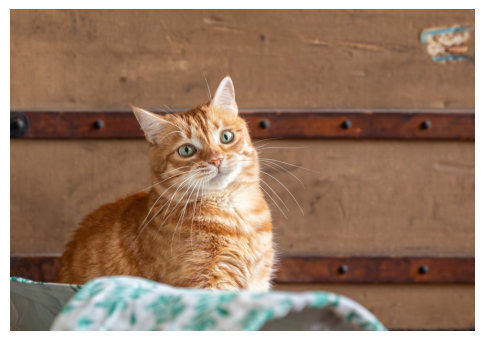

อันดับ 2: แมวสีส้มกำลังอ้าปากดูเหมือนกำลังส่งเสียง.
ระยะห่าง: 0.2840
ภาพ: image_file\cat3.jpg



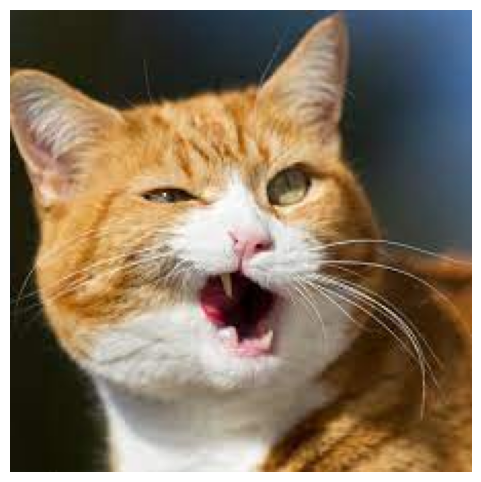

อันดับ 3: แมวสีขาวมีลายส้มกำลังนอนบนพื้นดินที่มีเศษหินเล็ก ๆ รอบตัว
ระยะห่าง: 0.2925
ภาพ: image_file\cat1.jpg



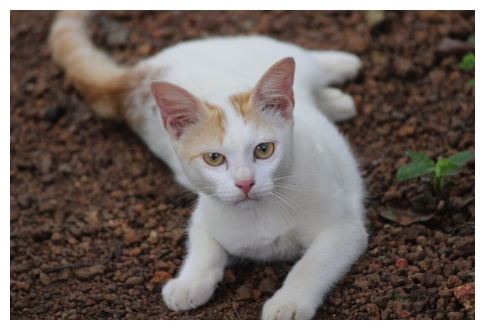

In [6]:
search_by_text("เเมวส้ม")

# กรณีค้นหาภาพด้วยภาพ


ค้นหาด้วยภาพ: D:/chat_irpc/Milvus_Image/image_file/002.jpg

อันดับ 1: ชายกำลังนั่งทำงานที่โต๊ะซึ่งมีแล็ปท็อป แก้วกาแฟ น้ำส้ม ครัวซองต์ สมุด และโทรศัพท์ วางอยู่บนโต๊ะ.
ระยะห่าง: 0.0000
ภาพ: image_file\002.jpg



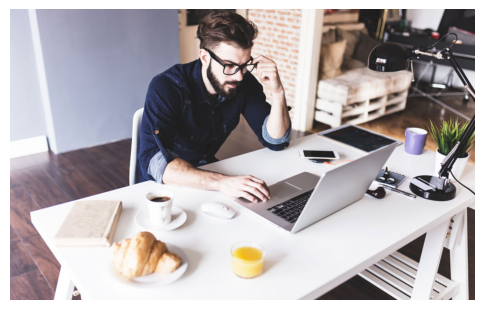

In [7]:
search_by_image("D:/chat_irpc/Milvus_Image/image_file/002.jpg")